In [1]:
# -*- coding: utf-8 -*-
#no batch norm
from __future__ import print_function, division

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, average_precision_score
from skimage.transform import resize
import scipy.io
import keras
import matplotlib.pyplot as plt
import itertools
import numpy as np
import time
import shutil
import os

Using TensorFlow backend.


In [2]:
# Fixing random state for reproducibility
seed = 19960925
np.random.seed(seed)
img_rows = 32
img_cols = 32
channels = 3
num_classes = 2


In [3]:
def load_TMI_data():
    # Load the dataset
    dataset = scipy.io.loadmat('TMI2015/training/training.mat')

    # Split into train and test. Values are in range [0..1] as float64
    X_train = np.transpose(dataset['train_x'], (3, 0, 1, 2))
    y_train = list(dataset['train_y'][0])
    
    X_test = np.transpose(dataset['test_x'], (3, 0, 1, 2))
    y_test = list(dataset['test_y'][0])
    
    # Change shape and range. 
    y_train = np.asarray(y_train).reshape(-1, 1)
    y_test = np.asarray(y_test).reshape(-1, 1)

#   1-> 0 : Non-nucleus. 2 -> 1: Nucleus
    y_test -= 1
    y_train -= 1

    # Resize to 32x32
    X_train_resized = np.empty([X_train.shape[0], 32, 32, X_train.shape[3]])
    for i in range(X_train.shape[0]):
        X_train_resized[i] = resize(X_train[i], (32, 32, 3), mode='reflect')

    X_test_resized = np.empty([X_test.shape[0], 32, 32, X_test.shape[3]])
    for i in range(X_test.shape[0]):
        X_test_resized[i] = resize(X_test[i], (32, 32, 3), mode='reflect')

    #Plotting a sample data:
    r, c = 5, 5
    fig, axs = plt.subplots(r, c)
#
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(X_train_resized[np.random.randint(0,6000)])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("./TMI_generators_output/tmi_training_random_sample.png")
    plt.suptitle('Non-nuclei Training Sample - label = 1')
    plt.show()
#
    r, c = 5, 5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(X_train_resized[np.random.randint(6000,8000)])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("./TMI_generators_output/tmi_training_random_sample.png")
    plt.suptitle('Nuclei Training Sample - label = 2')
    plt.show()
    
    # Normalize images from [0..1] to [-1..1]
    X_train_resized = 2 * X_train_resized - 1
    X_test_resized = 2 * X_test_resized - 1

    return X_train_resized, y_train, X_test_resized, y_test

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
def build_generator():
    # This model replaced any pooling layers with strided convolutions
    # Allowing it to learn its own spatial upsampling

    model = Sequential()

    model.add(Dense(128 * 8 * 8, activation="relu", input_dim=100))

    model.add(Reshape((8, 8, 128)))
    model.add(BatchNormalization(momentum=0.6))

    # fractionally-strided convolution, do not confuse with deconvolution operation
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))

    model.add(Activation("relu"))
    #model.add(BatchNormalization(momentum=0.6))

    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    #model.add(BatchNormalization(momentum=0.6))

    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))
    model.summary()

    noise = Input(shape=(100,))
    img = model(noise)

    return Model(noise, img)

def build_discriminator():
    # This model replaced any pooling layers with strided convolutions
    # Allowing it to learn its own spatial downsampling
    img_shape = (img_rows, img_cols, channels)

    # A Sequential model is a linear stack of layers.
    model = Sequential()

    # Create a Sequential model by simply adding layers via the .add() method
    # 32 filters, 3x3 kernel size, stride 2, input_shape is 28x28x1, same: pad so the output and input size are equal
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    # f(x) = alpha * x for x < 0, f(x) = x for x >= 0.
    # Leaky rectified activation worked well, especially for higher resolution modeling.
    # This is in contrast to the original GAN paper, which used the maxout activation
    model.add(LeakyReLU(alpha=0.2))
    # drops 25% of the input units
    #model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    #A zero-padding layer. Adds rows and columns of zeros to the image
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(Dropout(0.25))
    # Normalize the activations of the previous layer at each batch to reduce its covariance shift,
    # i.e., the amount that the distribution of each layer shift around.

    # This helps deal with training problems that arise due to poor initialization and helps gradient flow in deeper models.
    # This proved critical to get deep generators to begin learning, preventing the generator from collapsing all samples
    # to a single point which is a common failure mode observed in GANs.
    #
    # Directly applying batchnorm to all layers, however, resulted in sample oscillation and model instability.
    # This was avoided by not applying batchnorm to the generator output layer and the discriminator input layer
    model.add(BatchNormalization(momentum=0.6))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.6))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.summary()
#        plot_path = "discriminator.png"
#        plot_model(model, to_file=plot_path, show_shapes=True, show_layer_names=True)


    # instantiate a Keras tensor
    img = Input(shape=img_shape)
    features = model(img)

    # valid indicates if the image is real or fake
    valid = Dense(1, activation="sigmoid")(features)
    # iff the image is real, label indicates which type of image it is
    label = Dense(num_classes+1, activation="softmax")(features)

    # Given an img (x)  and a label(y), instantiate a Model.
    # Once instantiated, this model will include all layers required in the computation of y given x.
    return Model(img, [valid, label])

In [6]:
def train( X_train, y_train, X_test, y_test, epochs, batch_size, save_interval):

    # delete directory if exist and create it
    shutil.rmtree('TMI_generators_output', ignore_errors=True)
    os.makedirs("TMI_generators_output")

    #half_batch = int(batch_size / 2)
    half_batch = batch_size
    # Class weights:
    # To balance the difference in occurences of class labels.
    # 50% of labels that D trains on are 'fake'.
    # Weight = 1 / frequency
    cw1 = {0: 1, 1: 1}
    cw2 = {i: num_classes / half_batch for i in range(num_classes)}
    cw2[num_classes] = 1 / half_batch

    for epoch in range(epochs):
        # ---------------------
        #  Training the Discriminator
        # ---------------------
        lrate=0.0002
        if epoch > 100:
            lrate = 0.0001
        if epoch > 150:
            lrate = 0.00002
        # Select a random half batch of images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        # Draw random samples from a Gaussian distribution.
        noise = np.random.normal(0, 1, (half_batch, 100))
        # Generate a half batch of new images
        gen_imgs = generator.predict(noise)

        valid = np.ones((half_batch, 1))
        fake = np.zeros((half_batch, 1))

        # Convert labels to categorical one-hot encoding
        labels = to_categorical(y_train[idx], num_classes=num_classes+1)
        fake_labels = to_categorical(np.full((half_batch, 1), num_classes), num_classes=num_classes+1)

        # Train the discriminator (real classified as ones and fakes as zeros)
        # train_on_batch: Single gradient update over one batch of samples
        keras.backend.set_value(discriminator.optimizer.lr,lrate)
        d_loss_real = discriminator.train_on_batch(imgs, [valid, labels], class_weight=[cw1, cw2])
        d_loss_fake = discriminator.train_on_batch(gen_imgs, [fake, fake_labels], class_weight=[cw1, cw2])
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Training the Generator
        # ---------------------
        validity = np.ones((batch_size, 1))

        for i in range(10):
            noise = np.random.normal(0, 1, (batch_size, 100))
            # Train the generator (wants discriminator to mistake images as real)
            keras.backend.set_value(combined.optimizer.lr,lrate)
            g_loss = combined.train_on_batch(noise, validity, class_weight=[cw1, cw2])

        training_history["D_loss"].append(d_loss[0]);
        training_history["D_acc"].append(100*d_loss[3]);
        training_history["G_loss"].append(g_loss);
        training_history["G_acc"].append(100*d_loss[4]);

        print ("%d: Training D [loss: %.4f, acc: %.2f%% ] - G [loss: %.4f, acc: %.2f%%]" % (epoch, d_loss[0], 100*d_loss[3], g_loss, 100*d_loss[4]))
        evaluate_discriminator(X_test, y_test)

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)

In [7]:
def evaluate_discriminator( X_test, y_test):
    valid = np.ones((y_test.shape[0], 1))

    # Convert labels to categorical one-hot encoding
    labels = to_categorical(y_test, num_classes=num_classes+1)

    #  Evaluating the trained Discriminator
    scores = discriminator.evaluate(X_test, [valid, labels], verbose=0)

    print("Evaluating D [loss:  %.4f, bi-loss: %.4f, cat-loss: %.4f, bi-acc: %.2f%%, cat-acc: %.2f%%]\n" %
          (scores[0], scores[1], scores[2], scores[3]*100, scores[4]*100))
#        print("\nEvaluating D [loss:  %.4f, acc: %.2f%%]" % (scores[0], scores[3]*100))

    return (scores[0], scores[3]*100)

In [8]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images from [-1..1] to [0..1] just to display purposes.
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("./TMI_generators_output/tmi_%d.png" % epoch)
    plt.close()

In [9]:
def save_model():

    def save(model, model_name):
        model_path = "./TMI_saved_models/%s.json" % model_name
        weights_path = "./TMI_saved_models/%s_weights.hdf5" % model_name
        options = {"file_arch": model_path,
                    "file_weight": weights_path}
        json_string = model.to_json()
        open(options['file_arch'], 'w').write(json_string)
        model.save_weights(options['file_weight'])

    shutil.rmtree('TMI_saved_models', ignore_errors=True)
    os.makedirs("TMI_saved_models")

    save(generator, "TMI_gan_generator")
    save(discriminator, "TMI_gan_discriminator")
    save(combined, "TMI_gan_adversarial")

In [10]:
def plot_training_history():
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    plt.title('Training History')
    # summarize history for G and D accuracy
    axs[0].plot(range(1,len(training_history['D_acc'])+1),training_history['D_acc'])
    axs[0].plot(range(1,len(training_history['G_acc'])+1),training_history['G_acc'])
    axs[0].set_title('D and G Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(training_history['D_acc'])+1),len(training_history['D_acc'])/10)
    axs[0].set_yticks([n for n in range(0, 101,10)])
    axs[0].legend(['Discriminator', 'Generator'], loc='best')

    # summarize history for G and D loss
    axs[1].plot(range(1,len(training_history['D_loss'])+1),training_history['D_loss'])
    axs[1].plot(range(1,len(training_history['G_loss'])+1),training_history['G_loss'])
    axs[1].set_title('D and G Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(training_history['G_loss'])+1),len(training_history['G_loss'])/10)
    axs[1].legend(['Discriminator', 'Generator'], loc='best')
    plt.show()

In [11]:
def predict( X_test, y_test):

    # Generating a predictions from the discriminator over the testing dataset
    y_pred = discriminator.predict(X_test)

    # Formating predictions to remove the one_hot_encoding format
    y_pred = np.argmax(y_pred[1][:,:-1], axis=1)

    print ('\nOverall accuracy: %f%% \n' % (accuracy_score(y_test, y_pred) * 100))
    print ('\nAveP: %f%% \n' % (average_precision_score(y_test, y_pred) * 100))

    # Calculating and ploting a Classification Report
    class_names = ['Non-nunclei', 'Nuclei']
    print("Classification report:\n %s\n"
          % (classification_report(y_test, y_pred, target_names=class_names)))

    # Calculating and ploting Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
#        print("Confusion matrix:\n%s" % cm)

    plt.figure()
    plot_confusion_matrix(cm, class_names, title='Confusion matrix, without normalization')

    plt.figure()
    plot_confusion_matrix(cm, class_names, normalize=True, title='Normalized confusion matrix')

In [12]:
training_history = {
        'D_loss': [],
        'D_acc': [],
        'G_loss': [],
        'G_acc': [],
        }
        # TMI input shape (after resized)is 32x32x3

        # While previous GAN work has used momentum to accelerate training, we used the Adam optimizer
        # (Kingma & Ba, 2014) with tuned hyperparameters. We found the suggested learning rate of 0.002,
        # to be too high, using 0.0002 instead. Additionally, we found leaving the momentum term β1 at the
        # suggested value of 0.9 resulted in training oscillation and instability while reducing it to 0.5 helped
        # stabilize training
optimizer = Adam(0.0002, 0.5)
#build the generator
generator = build_generator()

# The generator takes noise as input and generates imgs
z = Input(shape=(100,))
img = generator(z)

        # Build discriminator's model
discriminator = build_discriminator()
# Compile discriminator's model, i.e. define its learning process
# binary crossentropy is used to distinguish among real or fake samples
# categorical entropy is to distinguish among which real category is (nuclei or non-nuclei)
discriminator.compile(
        loss=['binary_crossentropy', 'categorical_crossentropy'],
        loss_weights=[0.5, 0.5],
        optimizer=optimizer,
        metrics=['accuracy'])
# For the combined model we will only train the generator
discriminator.trainable = False

# For the combined model we will only train the generator
discriminator.trainable = False
# The discriminator takes generated images as input and determines validity
valid, _ =discriminator(img)

# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity
combined = Model(z, valid)
combined.compile(
        loss=['binary_crossentropy'], 
        optimizer=optimizer)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 128)       0         
_________________________________________________________________
up_s

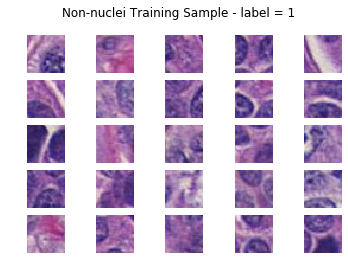

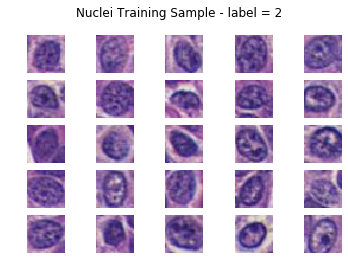

In [13]:
if __name__ == '__main__':

    X_train, y_train, X_test, y_test = load_TMI_data()

In [14]:
    start = time.time()
    
    epochs=200
    # Fit/Train the model
    train(X_train, y_train, X_test, y_test, epochs, batch_size=32, save_interval=5)

    end = time.time()
    print ("\nTraining time: %0.1f minutes \n" % ((end-start) / 60))

    #saved the trained model
    save_model()


#    evaluate the trained D model w.r.t unseen data (i.e. testing set)

    evaluate_discriminator(X_test, y_test)

Instructions for updating:
Use tf.cast instead.


c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: Training D [loss: 0.6932, acc: 42.19% ] - G [loss: 0.1412, acc: 31.25%]
Evaluating D [loss:  0.8869, bi-loss: 0.6770, cat-loss: 1.0968, bi-acc: 100.00%, cat-acc: 40.90%]

1: Training D [loss: 0.6540, acc: 46.88% ] - G [loss: 0.1618, acc: 34.38%]
Evaluating D [loss:  0.8948, bi-loss: 0.6942, cat-loss: 1.0953, bi-acc: 42.00%, cat-acc: 45.70%]

2: Training D [loss: 0.9475, acc: 23.44% ] - G [loss: 0.1251, acc: 34.38%]
Evaluating D [loss:  0.8979, bi-loss: 0.7011, cat-loss: 1.0948, bi-acc: 11.90%, cat-acc: 45.20%]

3: Training D [loss: 0.8590, acc: 9.38% ] - G [loss: 0.1851, acc: 62.50%]
Evaluating D [loss:  0.8950, bi-loss: 0.6970, cat-loss: 1.0930, bi-acc: 24.10%, cat-acc: 47.80%]

4: Training D [loss: 0.6513, acc: 35.94% ] - G [loss: 0.1638, acc: 50.00%]
Evaluating D [loss:  0.8957, bi-loss: 0.6995, cat-loss: 1.0920, bi-acc: 11.70%, cat-acc: 49.10%]

5: Training D [loss: 0.7360, acc: 48.44% ] - G [loss: 0.4272, acc: 45.31%]
Evaluating D [loss:  0.9032, bi-loss: 0.7158, cat-loss: 1.09

Evaluating D [loss:  0.8971, bi-loss: 0.7186, cat-loss: 1.0756, bi-acc: 0.00%, cat-acc: 78.80%]

48: Training D [loss: 0.7757, acc: 10.94% ] - G [loss: 0.5270, acc: 35.94%]
Evaluating D [loss:  0.8972, bi-loss: 0.7181, cat-loss: 1.0763, bi-acc: 0.00%, cat-acc: 74.20%]

49: Training D [loss: 0.5868, acc: 26.56% ] - G [loss: 0.5275, acc: 42.19%]
Evaluating D [loss:  0.8972, bi-loss: 0.7170, cat-loss: 1.0774, bi-acc: 0.30%, cat-acc: 69.00%]

50: Training D [loss: 0.6158, acc: 29.69% ] - G [loss: 0.4019, acc: 48.44%]
Evaluating D [loss:  0.8974, bi-loss: 0.7170, cat-loss: 1.0779, bi-acc: 0.20%, cat-acc: 71.10%]

51: Training D [loss: 0.7145, acc: 20.31% ] - G [loss: 0.6043, acc: 35.94%]
Evaluating D [loss:  0.8968, bi-loss: 0.7161, cat-loss: 1.0775, bi-acc: 0.00%, cat-acc: 73.10%]

52: Training D [loss: 0.6048, acc: 25.00% ] - G [loss: 0.8471, acc: 46.88%]
Evaluating D [loss:  0.8957, bi-loss: 0.7134, cat-loss: 1.0781, bi-acc: 0.30%, cat-acc: 81.00%]

53: Training D [loss: 0.5888, acc: 28.

95: Training D [loss: 0.5734, acc: 29.69% ] - G [loss: 0.4324, acc: 45.31%]
Evaluating D [loss:  0.8938, bi-loss: 0.7126, cat-loss: 1.0749, bi-acc: 0.50%, cat-acc: 87.90%]

96: Training D [loss: 0.5958, acc: 21.88% ] - G [loss: 0.5389, acc: 40.62%]
Evaluating D [loss:  0.8947, bi-loss: 0.7145, cat-loss: 1.0748, bi-acc: 0.00%, cat-acc: 89.10%]

97: Training D [loss: 0.5269, acc: 23.44% ] - G [loss: 0.6790, acc: 54.69%]
Evaluating D [loss:  0.8933, bi-loss: 0.7122, cat-loss: 1.0743, bi-acc: 0.00%, cat-acc: 89.80%]

98: Training D [loss: 0.5272, acc: 29.69% ] - G [loss: 0.6617, acc: 43.75%]
Evaluating D [loss:  0.8921, bi-loss: 0.7095, cat-loss: 1.0747, bi-acc: 0.10%, cat-acc: 90.60%]

99: Training D [loss: 0.5828, acc: 23.44% ] - G [loss: 0.5232, acc: 35.94%]
Evaluating D [loss:  0.8925, bi-loss: 0.7090, cat-loss: 1.0761, bi-acc: 0.00%, cat-acc: 91.20%]

100: Training D [loss: 0.5374, acc: 35.94% ] - G [loss: 0.5583, acc: 50.00%]
Evaluating D [loss:  0.8936, bi-loss: 0.7095, cat-loss: 1.

Evaluating D [loss:  0.8927, bi-loss: 0.7090, cat-loss: 1.0764, bi-acc: 0.00%, cat-acc: 93.00%]

143: Training D [loss: 0.4113, acc: 37.50% ] - G [loss: 0.7409, acc: 48.44%]
Evaluating D [loss:  0.8921, bi-loss: 0.7081, cat-loss: 1.0761, bi-acc: 0.20%, cat-acc: 92.90%]

144: Training D [loss: 0.4492, acc: 29.69% ] - G [loss: 0.7798, acc: 51.56%]
Evaluating D [loss:  0.8921, bi-loss: 0.7082, cat-loss: 1.0761, bi-acc: 0.00%, cat-acc: 92.90%]

145: Training D [loss: 0.4325, acc: 37.50% ] - G [loss: 0.7078, acc: 46.88%]
Evaluating D [loss:  0.8913, bi-loss: 0.7071, cat-loss: 1.0755, bi-acc: 0.70%, cat-acc: 93.00%]

146: Training D [loss: 0.4188, acc: 37.50% ] - G [loss: 0.6508, acc: 43.75%]
Evaluating D [loss:  0.8911, bi-loss: 0.7067, cat-loss: 1.0754, bi-acc: 1.50%, cat-acc: 92.70%]

147: Training D [loss: 0.3900, acc: 42.19% ] - G [loss: 0.8105, acc: 51.56%]
Evaluating D [loss:  0.8918, bi-loss: 0.7077, cat-loss: 1.0760, bi-acc: 0.40%, cat-acc: 92.50%]

148: Training D [loss: 0.4356, ac

190: Training D [loss: 0.3946, acc: 51.56% ] - G [loss: 0.6819, acc: 46.88%]
Evaluating D [loss:  0.8922, bi-loss: 0.7083, cat-loss: 1.0761, bi-acc: 0.50%, cat-acc: 92.40%]

191: Training D [loss: 0.3810, acc: 50.00% ] - G [loss: 0.7362, acc: 57.81%]
Evaluating D [loss:  0.8921, bi-loss: 0.7082, cat-loss: 1.0761, bi-acc: 0.50%, cat-acc: 92.40%]

192: Training D [loss: 0.3846, acc: 48.44% ] - G [loss: 0.6528, acc: 60.94%]
Evaluating D [loss:  0.8920, bi-loss: 0.7080, cat-loss: 1.0760, bi-acc: 0.60%, cat-acc: 92.80%]

193: Training D [loss: 0.3682, acc: 46.88% ] - G [loss: 0.6387, acc: 50.00%]
Evaluating D [loss:  0.8920, bi-loss: 0.7081, cat-loss: 1.0760, bi-acc: 0.50%, cat-acc: 92.80%]

194: Training D [loss: 0.3945, acc: 51.56% ] - G [loss: 0.7111, acc: 43.75%]
Evaluating D [loss:  0.8921, bi-loss: 0.7082, cat-loss: 1.0760, bi-acc: 0.50%, cat-acc: 92.80%]

195: Training D [loss: 0.4133, acc: 40.62% ] - G [loss: 0.7180, acc: 57.81%]
Evaluating D [loss:  0.8922, bi-loss: 0.7083, cat-los

(0.892099172115326, 0.3)

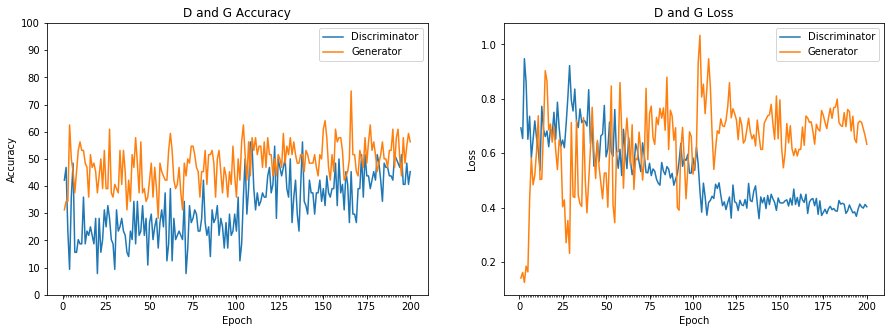

In [15]:
#    plot training graph
plot_training_history()


Overall accuracy: 92.700000% 


AveP: 92.022222% 

Classification report:
               precision    recall  f1-score   support

 Non-nunclei       0.88      0.99      0.93       500
      Nuclei       0.98      0.87      0.92       500

   micro avg       0.93      0.93      0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000




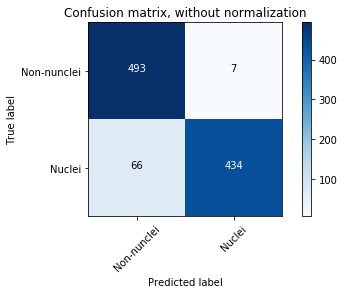

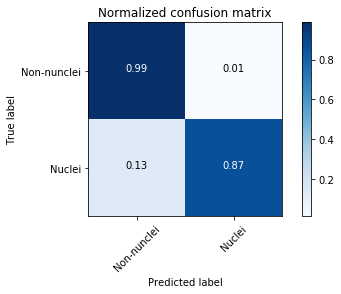

In [16]:
predict(X_test, y_test)